In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
# Read CSV and Convert data
matched_ratings = pd.read_csv("src/data/data_matched_beer_data/ratings.csv", header=[0, 1])
matched_ratings.columns = ['_'.join(col).strip() for col in matched_ratings.columns.values]
matched_ratings['ba_date'] = pd.to_datetime(matched_ratings['ba_date'], unit='s')
matched_ratings['rb_date'] = pd.to_datetime(matched_ratings['rb_date'], unit='s')
matched_ratings['ba_user_name'] = matched_ratings['ba_user_name'].str.lower()
matched_ratings['rb_user_name'] = matched_ratings['rb_user_name'].str.lower()

# Handle missing values in text columns
matched_ratings['rb_text'] = matched_ratings['rb_text'].fillna('')
matched_ratings['ba_text'] = matched_ratings['ba_text'].fillna('')

# Define keywords that make sense for newcomers
keywords = [
    "newcomer",
    "brand new beer",
    "just released",
    "just launched",
    "new release",
    "fresh release",
    "new arrival",
    "first batch",
    "first release",
    "limited release",
    "debut beer",
    "new to the market",
    "recently launched",
    "latest offering",
    "new addition"
]

# Use regex pattern for the keywords 
pattern = '|'.join([rf'\b{k}\b' for k in keywords])

# Search for keyword hits in 'rb_text' and 'ba_text', case-insensitive
matched_ratings['rb_keyword_present'] = matched_ratings['rb_text'].str.contains(
    pattern, flags=re.IGNORECASE, regex=True)
matched_ratings['ba_keyword_present'] = matched_ratings['ba_text'].str.contains(
    pattern, flags=re.IGNORECASE, regex=True)

# Filter for reviews with positive hits in either RB or BA
keyword_reviews = matched_ratings[
    matched_ratings['rb_keyword_present'] | matched_ratings['ba_keyword_present']
]

# Get the unique beer_ids
keyword_beers = keyword_reviews['ba_beer_id'].unique()

print("Confirmed newcomer beers based on review text:")
print(keyword_beers)
print()

# Read matched beer csv
beers = pd.read_csv("src/data/data_matched_beer_data/beers.csv")

# Get beer names from the matched beer df
filtered_beers = beers[beers['ba.5'].isin(keyword_beers)]

print("Confirmed newcomer beers names:")
print(filtered_beers["ba.6"])
filtered_beers.to_csv("TextAnalysis_Newcomers.csv", header=True)

Confirmed newcomer beers based on review text:
[  8668  49183  53039 137262 207342 253015  65150  64193 115467  32022
  30174  33960 283794  92907  71620  71073   1855   5411 257931 257429
  62403   3833  69461  49634 251452 187911 183179  55554  36594  81079
 112081  73949  75160  37201  37457  49662  36316  84642  36418 156482]

Confirmed newcomer beers names:
21554    Southampton Peconic County Reserve Ale
22113                                 Tesseract
22786                           Cache La Porter
25164                              Stoudts Pils
29379                                 Tafelbier
29420                           Bobhouse Bitter
29431                              Winter Wheat
29526                     Hometown Double Brown
29632                                Wood Devil
31190        Kentucky Bourbon Barrel Barleywine
32854                                  IPA (II)
32956     Daybreak (Orange Liqueur Barrel Aged)
33835      Newport Storm - Kim (Cyclone Series)
35717      

C:\Users\matti\AppData\Local\Temp\ipykernel_26028\2240916314.py:54: DtypeWarning: Columns (0,1,2,3,4,5,8,10,11,12,13,15,16,17,18,19,20,23,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  beers = pd.read_csv("src/data/data_matched_beer_data/beers.csv")


In [3]:
#Read the csv with the reviewdensity results and filter for only the keyword_beers
Newcomers = pd.read_csv("ReviewDensity_Newcomers_per_year.csv")
filtered_newcomers = Newcomers[Newcomers['ba_beer_id'].isin(keyword_beers)]
print(filtered_newcomers.head(100))
newcomer_beers = filtered_newcomers
newcomer_beers.to_csv("TextAnalysis_Matched_per_year.csv", header=True, index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC, na_rep='NaN')

# First, let's get the first review year for each beer
first_reviews = newcomer_beers.groupby('ba_beer_id')['year'].min().reset_index()
first_reviews = first_reviews.rename(columns={'year': 'first_review_year'})

# Create two separate dataframes
pre_2007_beers = first_reviews[first_reviews['first_review_year'] <= 2007]['ba_beer_id']
post_2007_beers = first_reviews[first_reviews['first_review_year'] > 2007]['ba_beer_id']

# Now filter the original dataset
pre_2007_data = newcomer_beers[newcomer_beers['ba_beer_id'].isin(pre_2007_beers)]
post_2007_data = newcomer_beers[newcomer_beers['ba_beer_id'].isin(post_2007_beers)]

# Print some basic statistics
print(f"Number of beers first reviewed before 2007: {len(pre_2007_beers)}")
print(f"Number of beers first reviewed in 2007 or later: {len(post_2007_beers)}")



      ba_beer_id  year  review_count                   ba_beer_name
173         3833  2002             3        AleSmith Speedway Stout
174         3833  2003             3        AleSmith Speedway Stout
175         3833  2004             6        AleSmith Speedway Stout
176         3833  2005             1        AleSmith Speedway Stout
177         3833  2006            10        AleSmith Speedway Stout
...          ...   ...           ...                            ...
3625        5411  2009             6                   Stoudts Pils
3626        5411  2010             2                   Stoudts Pils
3627        5411  2011             2                   Stoudts Pils
3628        5411  2012             2                   Stoudts Pils
3696       73949  2011             3  Sweetwater Dank Tank Ghoulash

[100 rows x 4 columns]
Number of beers first reviewed before 2007: 7
Number of beers first reviewed in 2007 or later: 10


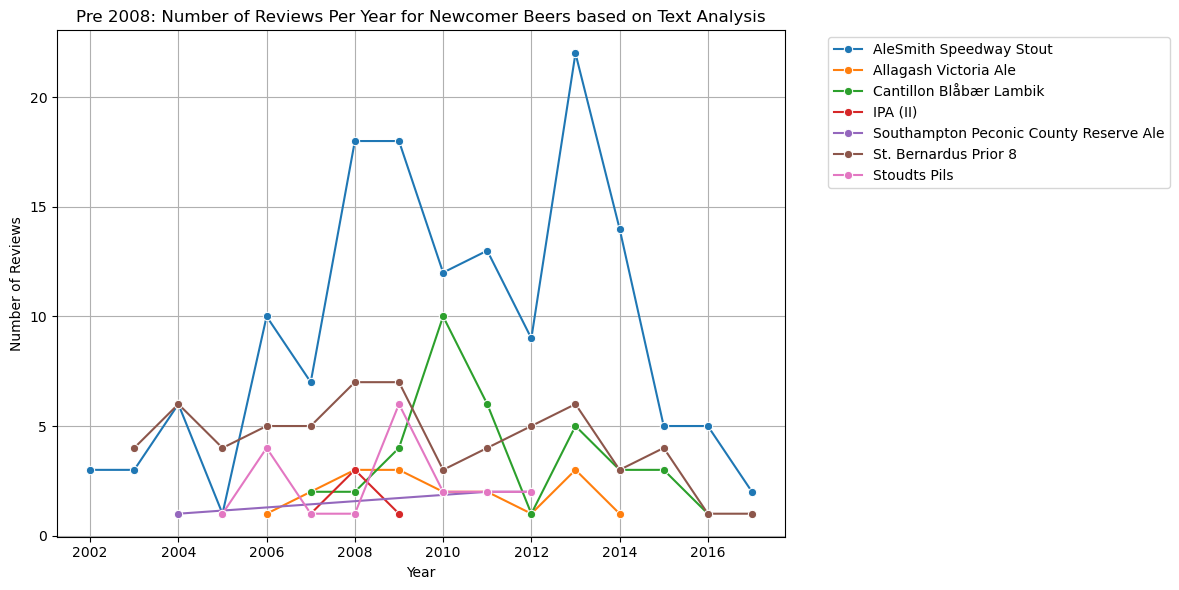

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=pre_2007_data[pre_2007_data['ba_beer_id'].isin(newcomer_beers['ba_beer_id'].head(100))],
    x='year',
    y='review_count',
    hue='ba_beer_name',
    marker='o',
    ax=ax
)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Reviews')
ax.set_title('Pre 2008: Number of Reviews Per Year for Newcomer Beers based on Text Analysis')
ax.grid(True)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

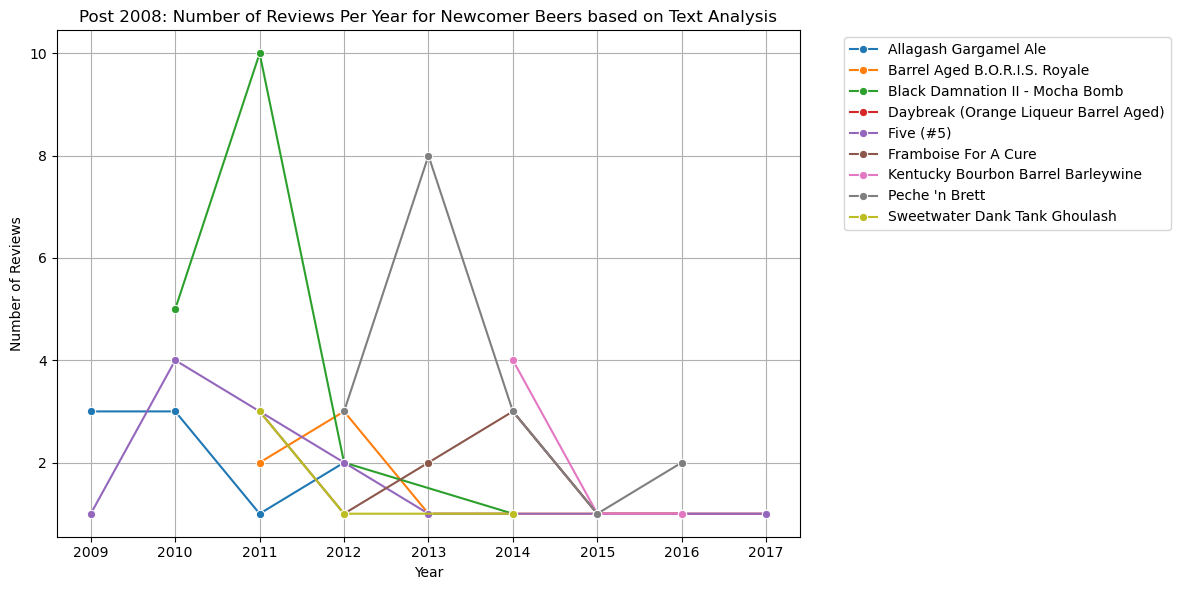

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=post_2007_data[post_2007_data['ba_beer_id'].isin(newcomer_beers['ba_beer_id'].head(100))],
    x='year',
    y='review_count',
    hue='ba_beer_name',
    marker='o',
    ax=ax
)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Reviews')
ax.set_title('Post 2008: Number of Reviews Per Year for Newcomer Beers based on Text Analysis')
ax.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

rating and beer types
newcomers where are they
we came with idea of underdog beers / less popular styles thanks to the newcomers